### Prevendo Turnover em uma Empresa ###

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import NearMiss
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


**Preparação dos dados**

In [22]:
rh = pd.read_csv('datasets/employee_data.csv',header=0)
person = pd.read_csv('datasets/random_person.csv')
rh.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0


In [17]:
rh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14249 non-null  int64  
 1   department         13540 non-null  object 
 2   filed_complaint    2058 non-null   float64
 3   last_evaluation    12717 non-null  float64
 4   n_projects         14249 non-null  int64  
 5   recently_promoted  300 non-null    float64
 6   salary             14249 non-null  object 
 7   satisfaction       14068 non-null  float64
 8   status             14249 non-null  object 
 9   tenure             14068 non-null  float64
 10  full_name          14249 non-null  object 
 11  gender             14249 non-null  object 
 12  state              14249 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 1.4+ MB


In [23]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14966 entries, 0 to 14965
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_name  14966 non-null  object
 1   gender     14966 non-null  object
 2   state      14966 non-null  object
dtypes: object(3)
memory usage: 350.9+ KB


In [16]:
rh = pd.concat([rh, person], axis=1, join="inner")

In [18]:
rh

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,full_name,gender,state
0,221,engineering,NaN,0.932868,4,NaN,low,0.829896,Left,5.0,Robert Ortiz,M,Colorado
1,232,support,NaN,NaN,3,NaN,low,0.834544,Employed,2.0,Ismael Moore,M,Alaska
2,184,sales,NaN,0.788830,3,NaN,medium,0.834988,Employed,3.0,Patricia Ford,F,New Jersey
3,206,sales,NaN,0.575688,4,NaN,low,0.424764,Employed,2.0,Ward Graham,M,New Jersey
4,249,sales,NaN,0.845217,3,NaN,low,0.779043,Employed,3.0,Harry Bellows,M,Virginia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14244,178,IT,NaN,0.735865,5,NaN,low,0.263282,Employed,5.0,Jerome Scott,M,Arkansas
14245,257,sales,NaN,0.638604,3,NaN,low,0.868209,Employed,2.0,Craig Jackson,M,Georgia
14246,232,finance,1.0,0.847623,5,NaN,medium,0.898917,Left,5.0,Kim Newsome,M,Colorado
14247,130,IT,NaN,0.757184,4,NaN,medium,0.641304,Employed,3.0,William Kendall,M,Virginia


In [4]:
rh['filed_complaint'].fillna(0, inplace=True)
rh['recently_promoted'].fillna(0,inplace=True)

In [5]:
# Transformando as colunas filed_complaint e recently_promoted em tipos de dados inteiros
rh['filed_complaint'] = rh['filed_complaint'].astype('Int64')
rh['recently_promoted'] = rh['recently_promoted'].astype('Int64')

In [6]:
rh['last_evaluation'].fillna(rh['last_evaluation'].mean(),inplace=True)

In [7]:
# Verificando os valores da coluna department 
rh['department'].unique()

array(['engineering', 'support', 'sales', 'IT', 'product', 'marketing',
       'temp', 'procurement', 'finance', nan, 'management',
       'information_technology', 'admin'], dtype=object)

In [8]:
# IT é o mesmo que information_Technology, por isso iremos inserir a mesma info para ambos
rh['department'].replace('information_technology', 'IT', inplace=True)

In [9]:
# Removendo registros com valores ausentes no dataset
rh.dropna(subset=['department', 'tenure'], inplace=True)

In [10]:
rh.reset_index(drop=True, inplace=True)

**Análise dos dados**

In [11]:
rh.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000,13359.000000
mean,201.203159,0.145071,0.718503,3.807845,0.021334,0.622194,3.504155
std,49.930370,0.352185,0.164458,1.235721,0.144500,0.250476,1.473922
min,96.000000,0.000000,0.316175,2.000000,0.000000,0.040058,2.000000
25%,156.000000,0.000000,0.577606,3.000000,0.000000,0.451782,3.000000
50%,200.000000,0.000000,0.718477,4.000000,0.000000,0.654061,3.000000
75%,245.000000,0.000000,0.857885,5.000000,0.000000,0.825668,4.000000
max,310.000000,1.000000,1.000000,7.000000,1.000000,1.000000,10.000000


Text(0, 0.5, '% Percentual')

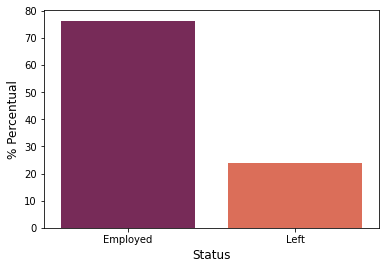

In [12]:
perc = rh['status'].value_counts(normalize=True).mul(100).round(1)
total = rh['status'].value_counts().index

sns.barplot(x=total, y=perc,data=rh, palette='rocket')
plt.xlabel("Status", size=12)
plt.ylabel("% Percentual", size=12)

c:\users\rapha\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


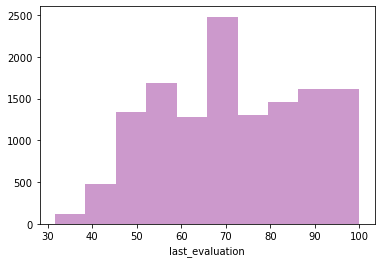

In [13]:
sns.distplot(rh['last_evaluation'].mul(100), kde=False, bins=10, color='purple')

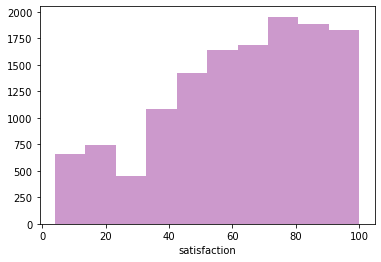

In [14]:
sns.distplot(rh['satisfaction'].mul(100), kde=False, bins=10, color='purple')

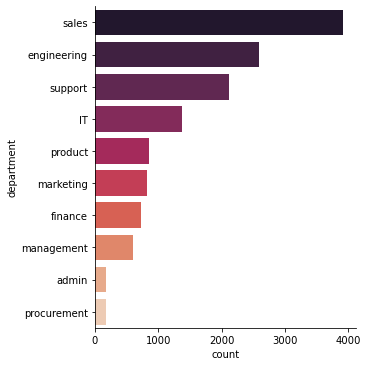

In [15]:
sns.catplot(y="department", kind="count", palette="rocket", data=rh, order= rh['department'].value_counts().index)

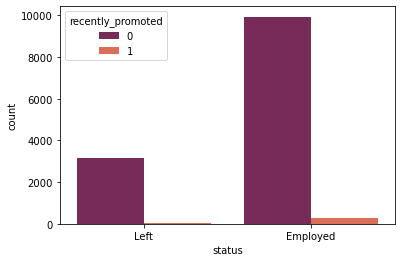

In [16]:
sns.countplot(x='status',hue='recently_promoted',palette='rocket', data=rh)

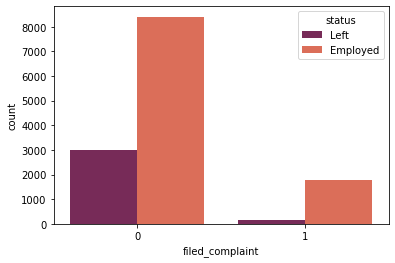

In [17]:
sns.countplot(x='filed_complaint',hue='status',palette='rocket', data=rh)

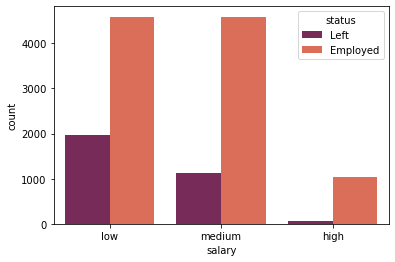

In [18]:
# Salário
sns.countplot(x='salary',data=rh,hue='status', palette='rocket')

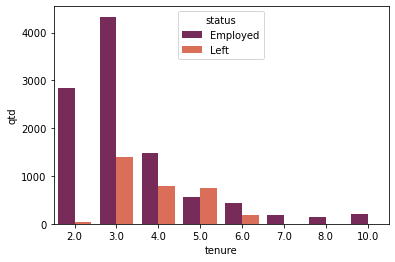

In [19]:
agg_tenure = rh.groupby(['tenure','status']).size()
agg_tenure = agg_tenure.to_frame().reset_index()
agg_tenure = agg_tenure.rename(columns= {0: 'qtd'})

sns.barplot(x='tenure',y='qtd', data=agg_tenure,hue='status', palette='rocket')

### Encoding ###

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

colunas = ["department", "salary"]

df_col=list(colunas)

for i in range(len(df_col)):
    rh[df_col[i]] = le.fit_transform(rh[df_col[i]])
    
rh.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,2,0,0.932868,4,0,1,0.829896,Left,5.0
1,232,9,0,0.718477,3,0,1,0.834544,Employed,2.0
2,184,8,0,0.788830,3,0,2,0.834988,Employed,3.0
3,206,8,0,0.575688,4,0,1,0.424764,Employed,2.0
4,249,8,0,0.845217,3,0,1,0.779043,Employed,3.0


In [21]:
# Dividindo os primeiros 1000 registros para deploy
rh_deploy = rh.iloc[0:999]
rh_deploy.drop(columns='status', inplace=True)
rh_deploy.to_csv('turnover_deploy.csv')

rh = rh.iloc[1000:]


c:\users\rapha\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
# Separando a classe das features 
y = rh['status']
X = rh.drop(columns="status")

### Normalizando ###

In [23]:
# Escala os dados de treino e teste
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)

### Balanceando as classes ###

**NearMiss**

In [ ]:
nr = NearMiss()
X, y = nr.fit_resample(X, y)

**RandomUnderSampler**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler()
X, y = us.fit_resample(X,y)

**SMOTE**

In [24]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X, y = smt.fit_resample(X, y)

In [25]:
# Verificando o balanceamento das classes 
y.value_counts()

Employed    9445
Left        9445
Name: status, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.35, stratify=y, random_state=4) 
# rodar modelo com nearmiss, standardscaler e svm otimizado

**Treinando com SVM**

In [27]:
clf = svm.SVC(probability=True).fit(X_train,y_train)
clf

SVC(probability=True)

In [28]:
y_previsto = clf.predict(X_test)
y_previsto

array(['Left', 'Employed', 'Employed', ..., 'Employed', 'Left',
       'Employed'], dtype=object)

In [29]:
y_percentual= clf.predict_proba(X_test)
print(y_percentual)

[[0.29806582 0.70193418]
 [0.97342921 0.02657079]
 [0.9717882  0.0282118 ]
 ...
 [0.88511422 0.11488578]
 [0.03357955 0.96642045]
 [0.99814508 0.00185492]]


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_previsto)

0.9444948578342408

Confusion Matrix


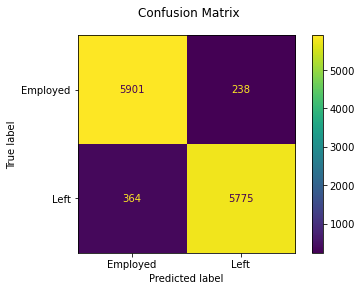

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt
disp = metrics.plot_confusion_matrix(clf,X_train,y_train)
disp.figure_.suptitle('Confusion Matrix')
print('Confusion Matrix')
plt.show()

In [32]:
from sklearn.model_selection import GridSearchCV

param_dict = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

grid_svm = GridSearchCV(clf,
                    param_grid = param_dict,
                    verbose = 3)
grid_svm.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............................C=1, kernel=linear; total time=  17.8s
[CV 2/5] END .............................C=1, kernel=linear; total time=  17.6s
[CV 3/5] END .............................C=1, kernel=linear; total time=  20.3s
[CV 4/5] END .............................C=1, kernel=linear; total time=  21.0s
[CV 5/5] END .............................C=1, kernel=linear; total time=  19.9s
[CV 1/5] END ................................C=1, kernel=rbf; total time=   8.3s
[CV 2/5] END ................................C=1, kernel=rbf; total time=   8.4s
[CV 3/5] END ................................C=1, kernel=rbf; total time=   7.2s
[CV 4/5] END ................................C=1, kernel=rbf; total time=   8.6s
[CV 5/5] END ................................C=1, kernel=rbf; total time=   7.6s
[CV 1/5] END ............................C=10, kernel=linear; total time= 1.2min
[CV 2/5] END ............................C=10, ke

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')}, verbose=3)

In [33]:
y_previsto = grid_svm.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_previsto)

0.9581064730792499

Confusion Matrix


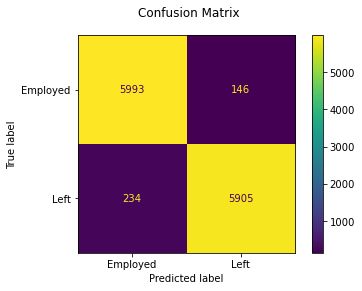

In [35]:
from sklearn import metrics
import matplotlib.pyplot as plt
disp = metrics.plot_confusion_matrix(grid_svm,X_train,y_train)
disp.figure_.suptitle('Confusion Matrix')
print('Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print (classification_report(y_test, y_previsto))

              precision    recall  f1-score   support

    Employed       0.95      0.96      0.96      3306
        Left       0.96      0.95      0.96      3306

    accuracy                           0.96      6612
   macro avg       0.96      0.96      0.96      6612
weighted avg       0.96      0.96      0.96      6612



### KNN ###

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
resultado = knn.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, resultado)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print (classification_report(y_test, resultado))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
disp = metrics.plot_confusion_matrix(knn,X_test,y_test)
disp.figure_.suptitle('Confusion Matrix')
print('Confusion Matrix')
plt.show()

In [ ]:
knn_params = {
'n_neighbors': [3,4,5,6],
'weights': ['uniform','distance'],
'metric':['euclidean','manhattan']
}

grid_knn = GridSearchCV(
	knn,
	knn_params,
	verbose = 3)

grid_knn.fit(X_train, y_train)

In [ ]:
resultado = grid_knn.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, resultado)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print (classification_report(y_test, resultado))

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
disp = metrics.plot_confusion_matrix(grid_knn,X_test,y_test)
disp.figure_.suptitle('Confusion Matrix')
print('Confusion Matrix')
plt.show()